In [1]:
%matplotlib inline

In [2]:
import holidays
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [3]:
crime = pd.read_csv('data/train.csv', parse_dates=['Dates'])
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null object
Descript      878049 non-null object
DayOfWeek     878049 non-null object
PdDistrict    878049 non-null object
Resolution    878049 non-null object
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 60.3+ MB


In [4]:
crime.head(3)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414


## Data Cleaning

In [5]:
# Convert str cols to categories if reasonable.
print(f"{'Feature':<15} Number of Unique Values" + '\n')
for col_name in crime.select_dtypes('object'):
    num_unique = crime[col_name].unique().size
    print(f'{col_name:<15} {num_unique}')
    if num_unique < 50:
        crime[col_name] = crime[col_name].astype('category')

Feature         Number of Unique Values

Category        39
Descript        879
DayOfWeek       7
PdDistrict      10
Resolution      17
Address         23228


In [6]:
# Memory significantly reduced.
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
Dates         878049 non-null datetime64[ns]
Category      878049 non-null category
Descript      878049 non-null object
DayOfWeek     878049 non-null category
PdDistrict    878049 non-null category
Resolution    878049 non-null category
Address       878049 non-null object
X             878049 non-null float64
Y             878049 non-null float64
dtypes: category(4), datetime64[ns](1), float64(2), object(2)
memory usage: 36.8+ MB


In [7]:
print(f"{'Feature':<15} Null Values" + '\n')
for col_name in crime:
    print(f'{col_name:<15} {crime[col_name].isnull().sum()}')

Feature         Null Values

Dates           0
Category        0
Descript        0
DayOfWeek       0
PdDistrict      0
Resolution      0
Address         0
X               0
Y               0


In [8]:
print(f"{'# of crime categories:':>15} {crime.Category.unique().size}")

# of crime categories: 39


In [9]:
print("Categories that made up more than 5% of crimes:")
cat_counts = crime.Category.value_counts(normalize=True)
cat_counts[cat_counts.values > .05]

Categories that made up more than 5% of crimes:


LARCENY/THEFT     0.199192
OTHER OFFENSES    0.143707
NON-CRIMINAL      0.105124
ASSAULT           0.087553
DRUG/NARCOTIC     0.061467
VEHICLE THEFT     0.061251
VANDALISM         0.050937
Name: Category, dtype: float64

## Processing and Train/Test Split
Before fitting models, we want to get some sense of the data. We split it into
train and test sets first to avoid data leakage. (Note that while random variability 
is an imortant part of the model fitting process, this is one area that requires
reproducability, so a random state is used.) The dataset is large enough that a
90/10 train/test split should be acceptable.

In [10]:
def feature_dates(df):
    """Add categorical feature showing part of day."""
    labels = ['Night', 'Morning', 'Afternoon', 'Evening']
    df['Daypart'] = pd.cut(df.Dates.dt.hour, bins=4, labels=labels)
    df['Hour'] = df.Dates.dt.hour
    df['Month'] = df.Dates.dt.month
    df['Day'] = df.Dates.dt.day
    return df

In [11]:
def feature_holiday(df):
    """Add boolean feature showing if crime occurred on a holiday."""
    us_holidays = [date.strftime('%m-%d-%Y') for date in 
               list(holidays.US(years=range(2003, 2016)).keys())]
    df['Dt'] = pd.to_datetime(df['Dates'].dt.date)
    df['Is_Holiday'] = np.where(df['Dt'].isin(us_holidays), 1, 0)
    df = df.drop(columns='Dt', axis=1)
    return df

In [12]:
def feature_corner(df):
    """Add boolean feature showing if location was at a street corner."""
    df['Is_Corner'] = np.where(df['Address'].str.contains("/"), 1, 0)
    return df

In [13]:
def feature_resolved(df):
    """Add feature showing if crime was resolved."""
    df['Is_Resolved'] = np.where(df['Resolution'] != "NONE", 1, 0)
    return df

In [14]:
def process_features(df, funs=[feature_dates, feature_holiday, 
                              feature_corner, feature_resolved]):
    """Process all features."""
    for fun in funs:
        df = fun(df)
    return df

In [15]:
def process_labels(df):
    """Clean up labels and drop un-used categories. Group data into three
    major categories: Violent crime, deviant behavior, and theft (the most
    common type of crime)."""
    df['Category'] = df.Category.replace('TREA', 'TRESPASS')
    drop = ["NON-CRIMINAL", "MISSING PERSON",
        "SUSPICIOUS OCC", "SUICIDE", "RECOVERED VEHICLE", "OTHER OFFENSES",
        "BAD CHECKS", "BRIBERY", "EMBEZZLEMENT", "EXTORTION", 
        "FAMILY OFFENSES", "GAMBLING", "PORNOGRAPHY/OBSCENE MAT", 
        "SECONDARY CODES", "SEX OFFENSES NON FORCIBLE", "ARSON",
        "DISORDERLY CONDUCT", "DRIVING UNDER THE INFLUENCE", "WEAPON LAWS", 
        "LIQUOR LAWS", "LOITERING","RUNAWAY","WARRANTS",
        "FORGERY/COUNTERFEITING","KIDNAPPING","FRAUD","VANDALISM"]
    df = df[~df.Category.isin(drop)]
    df['Category'] = df.Category.replace(["ASSAULT",'SEX OFFENSES FORCIBLE'],
                                         "violent")
    df['Category'] = df.Category.replace(["DRUG/NARCOTIC",'DRUNKENNESS', 
                                          "PROSTITUTION"], "deviant")
    df['Category'] = df.Category.replace(["BURGLARY",'LARCENY/THEFT', 
                                          "STOLEN PROPERTY", "TRESPASS", 
               "ROBBERY", "THEFT", "VEHICLE THEFT"], "theft")
    return df

In [16]:
def process_data(df):
    """Process labels first so features are only created for rows being kept.
    """
    df = process_labels(df)
    df = process_features(df)
    return df

In [17]:
def feature_dummies(df):
    """Convert categorical vars to dummies."""
    cols = ['DayOfWeek', 'PdDistrict', 'Daypart', 'Hour', 'Month', 'Day']
    for col in cols:
        df = pd.concat((df, pd.get_dummies(df[col], prefix=col)), axis=1)
        df = df.drop(columns=col)
    return df

In [18]:
crime.shape

(878049, 9)

In [19]:
crime_clean = process_data(crime)

In [20]:
crime_clean.shape
del crime

In [21]:
feature_idx = np.r_[0, 3:5, 7:16]
X = crime_clean.iloc[:, feature_idx]
y = crime_clean['Category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05, 
                                                    random_state=42)

In [22]:
for df in [X_train, X_test, y_train, y_test]:
    print(df.shape)

(424941, 12)
(22366, 12)
(424941,)
(22366,)


### EDA on training data

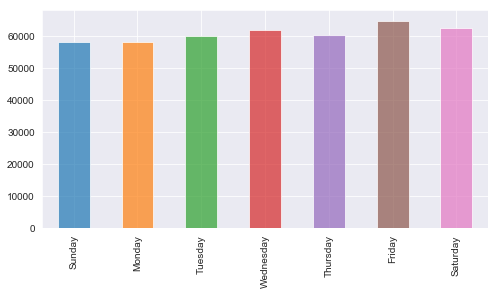

In [23]:
weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
            'Saturday']
weekday_counts = X_train.DayOfWeek.value_counts(sort=False)
sorted_counts = pd.Series([weekday_counts[day] for day in weekdays])
sorted_counts.plot.bar(alpha=.7, figsize=(8, 4))
plt.xticks(ticks=range(7), labels=weekdays)
plt.show()

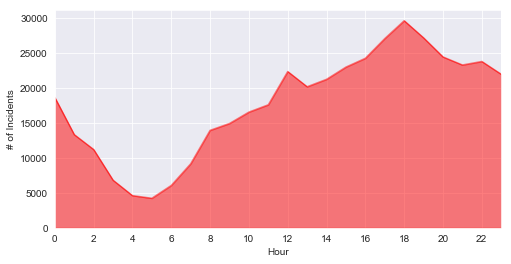

In [24]:
hour_counts = X_train.Dates.dt.hour.value_counts(sort=False)
hour_counts.plot(kind='area', alpha=.5, color='red', figsize=(8, 4))
plt.xlim(0, 23)
plt.xticks(range(0, 24, 2))
plt.xlabel('Hour')
plt.ylabel('# of Incidents')
plt.show()

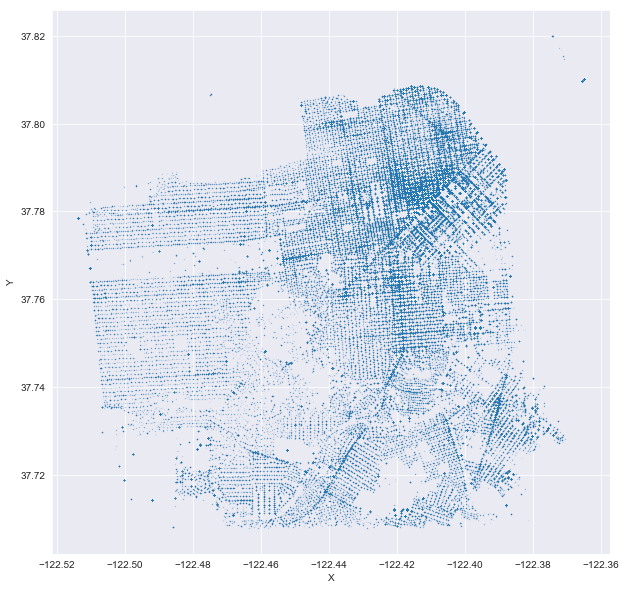

In [25]:
X_train[X_train.Y < 80].plot(x='X', y='Y', kind='scatter', s=.05, alpha=.25,
                             figsize=(10, 10))
plt.show()

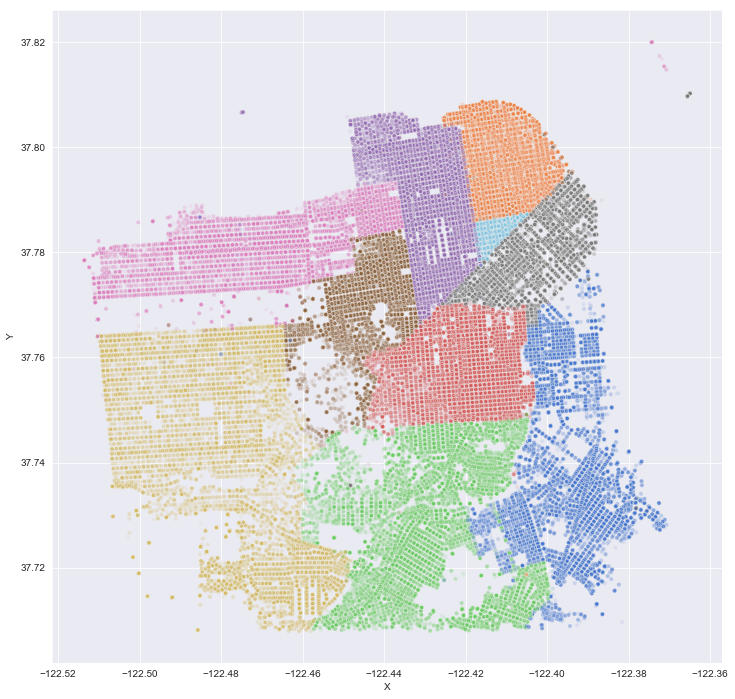

In [26]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='X', y='Y', data=X_train[X_train.Y < 40], hue='PdDistrict',
          palette='muted', size=.01, alpha=0.1, legend=False, ax=ax)
plt.show()

In [27]:
train = pd.concat((X_train, y_train), axis=1)
train.head()

,Dates,DayOfWeek,PdDistrict,X,Y,Daypart,Hour,Month,Day,Is_Holiday,Is_Corner,Is_Resolved,Category
88706,2014-03-08 05:18:00,Saturday,NORTHERN,-122.418581,37.788191,Night,5,3,8,0,0,0,theft
559887,2007-06-16 00:01:00,Saturday,SOUTHERN,-122.411279,37.771579,Night,0,6,16,0,1,0,theft
285502,2011-06-17 22:00:00,Friday,SOUTHERN,-122.410066,37.774991,Evening,22,6,17,0,1,0,theft
80111,2014-04-19 00:17:00,Saturday,NORTHERN,-122.419641,37.785433,Night,0,4,19,0,1,1,deviant
459459,2008-11-16 00:01:00,Sunday,MISSION,-122.417333,37.763572,Night,0,11,16,0,1,1,deviant


In [28]:
train.pivot_table(values='Is_Holiday', index='Category', 
                  aggfunc=['sum', 'mean'])

,sum,mean
,Is_Holiday,Is_Holiday
Category,,
deviant,1860,0.029812
theft,8781,0.030777
violent,2593,0.033572


In [29]:
train.pivot_table(values='Is_Corner', index='Category', 
                  aggfunc=['sum', 'mean'])

,sum,mean
,Is_Corner,Is_Corner
Category,,
deviant,25902,0.415163
theft,84264,0.295337
violent,15361,0.198884


In [30]:
train.pivot_table(values='Is_Resolved', index='Category', 
                  aggfunc=['sum', 'mean'])

,sum,mean
,Is_Resolved,Is_Resolved
Category,,
deviant,57041,0.914265
theft,41121,0.144125
violent,32567,0.421656


In [31]:
train.groupby(['Category', 'DayOfWeek']).size()

Category  DayOfWeek
deviant   Friday        8724
          Monday        8292
          Saturday      7637
          Sunday        7213
          Thursday      9946
          Tuesday       9868
          Wednesday    10710
theft     Friday       44834
          Monday       39108
          Saturday     42809
          Sunday       38598
          Thursday     40020
          Tuesday      39569
          Wednesday    40377
violent   Friday       11150
          Monday       10613
          Saturday     12015
          Sunday       12140
          Thursday     10314
          Tuesday      10349
          Wednesday    10655
dtype: int64

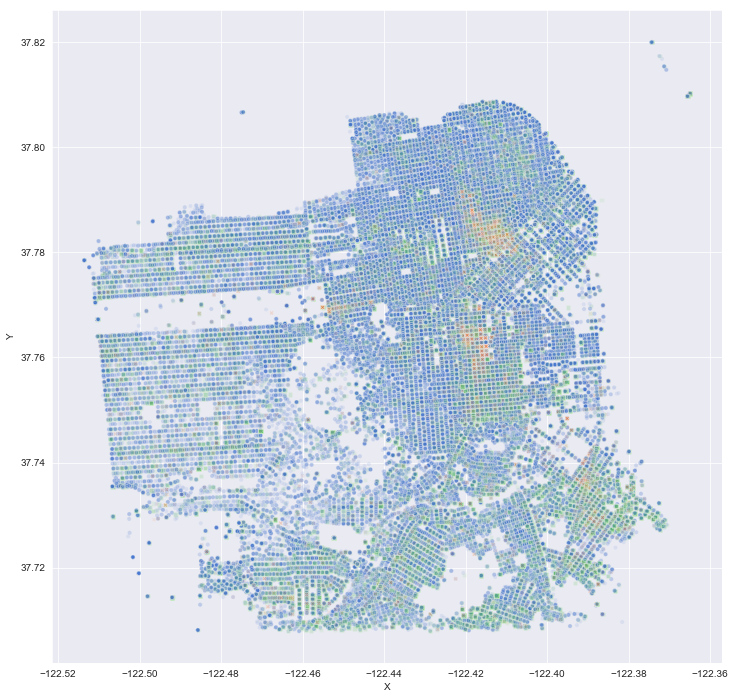

In [32]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x='X', y='Y', data=train[train.Y < 40], style='Category', 
                    hue='Category', palette='muted', size=.01, alpha=0.1,
                    legend=False, ax=ax)
plt.show()

### Finish preparing data for modeling by adding all dummy cols

In [33]:
X_train = feature_dummies(X_train).drop(columns='Dates')
X_test = feature_dummies(X_test).drop(columns='Dates')

## Modeling

## Fit Random Forest Classifier

In [34]:
# drop langitude and latitude from data set
X_train1 = X_train.iloc[:,2:]
X_test1 = X_test.iloc[:,2:]

#### check features importance with RandomForest classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

 
rf =  RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_f1_score = f1_score(y_test, y_pred, average='weighted') #use f1_score weighted because the data is unbalanced 
print(f"{rf_f1_score:.4f}")

0.7660


array([0.15022326, 0.15080338, 0.00432008, 0.01437044, 0.17169348,
       0.0111676 , 0.01059348, 0.01056474, 0.00989008, 0.0104349 ,
       0.01143137, 0.01023228, 0.00258889, 0.00322707, 0.0032813 ,
       0.00487941, 0.00347959, 0.0019077 , 0.00284823, 0.00441624,
       0.00232738, 0.01936158, 0.00364663, 0.00321225, 0.00379106,
       0.00362185, 0.00260288, 0.00248911, 0.0023564 , 0.0016877 ,
       0.00142382, 0.00119381, 0.0021273 , 0.00253891, 0.00294235,
       0.00333098, 0.00341735, 0.00338964, 0.00385721, 0.00357073,
       0.00387099, 0.00423833, 0.00419885, 0.00381875, 0.00355327,
       0.00412872, 0.00401983, 0.0035401 , 0.00378327, 0.00385793,
       0.0089764 , 0.00892693, 0.00953424, 0.00978618, 0.01008146,
       0.00941204, 0.00918025, 0.00917457, 0.00975777, 0.01009477,
       0.00916497, 0.00811505, 0.00586967, 0.00576513, 0.00596238,
       0.00625944, 0.00625273, 0.00609579, 0.00611219, 0.00621843,
       0.00611845, 0.00583997, 0.00561069, 0.00578854, 0.00607

In [36]:
d=dict()
for name,n in zip(list(X_train.columns),rf.feature_importances_):
    d[name]=n
features_list=list(d.items())      
features_list.sort(key=lambda x: -x[1])
features_most_important_to_least = [f[0] for f in features_list]

In [37]:
features_most_important_to_least[0:5]

['Is_Resolved', 'Y', 'X', 'PdDistrict_TENDERLOIN', 'Is_Corner']

In [38]:
rf =  RandomForestClassifier()
rf.fit(X_train1, y_train)
#rf_acc = rf.score(X_test, y_test)
y_pred = rf.predict(X_test1)
rf_f1_score = f1_score(y_test, y_pred, average='weighted')
print(f"{rf_f1_score:.4f}")

0.7174


array([0.00553851, 0.02711022, 0.21377899, 0.01726385, 0.01489278,
       0.01467826, 0.01354765, 0.01556994, 0.01560888, 0.01484494,
       0.00545057, 0.00706404, 0.00620518, 0.00701755, 0.0060843 ,
       0.0048478 , 0.00457438, 0.00877646, 0.00625026, 0.02389134,
       0.00442826, 0.00250184, 0.00294702, 0.00303637, 0.00299108,
       0.00262665, 0.002433  , 0.002309  , 0.0016654 , 0.0012201 ,
       0.00242849, 0.00351923, 0.00433613, 0.00450116, 0.00492541,
       0.00494585, 0.00526045, 0.00449618, 0.00514039, 0.00591671,
       0.00597473, 0.00602755, 0.00432812, 0.0047855 , 0.0051626 ,
       0.00527532, 0.0053243 , 0.00436553, 0.01373253, 0.01358763,
       0.01467905, 0.0155209 , 0.01515055, 0.01425023, 0.01410685,
       0.01313846, 0.01458217, 0.01521706, 0.01388403, 0.01134459,
       0.0077812 , 0.00917157, 0.00922257, 0.00962323, 0.00991855,
       0.00931886, 0.0097596 , 0.00989678, 0.00968656, 0.00882341,
       0.00881067, 0.00897091, 0.0094247 , 0.00902446, 0.00903

In [40]:
d=dict()
for name,n in zip(list(X_train1.columns),rf.feature_importances_):
    d[name]=n
features_list=list(d.items())      
features_list.sort(key=lambda x: -x[1])
features_most_important_to_least = [f[0] for f in features_list]

In [41]:
features_most_important_to_least[0:5]

['Is_Resolved',
 'Is_Corner',
 'PdDistrict_TENDERLOIN',
 'DayOfWeek_Friday',
 'DayOfWeek_Tuesday']

### Fit different models and compare F1_score among them

In [ ]:
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline


In [144]:
pipe_rf = Pipeline([('clf', RandomForestClassifier())])
pipe_bnb = Pipeline([('clf', BernoulliNB())])
pipe_gnb = Pipeline([('scl', MinMaxScaler()),          # Transformer: MinMaxScaler  
                    ('clf',  GaussianNB())])
pipe_cnb = Pipeline([('scl', MinMaxScaler()),          # Transformer: MinMaxScaler  
                    ('clf', ComplementNB())])
pipelines = [pipe_rf, pipe_bnb, pipe_gnb, pipe_cnb]
grid_params_list = [dict(),
                    dict(clf__alpha=[0, 0.1, 0.5, 0.7, 1]),
                    dict(),
                    dict(clf__alpha=[0, 0.1, 0.5, 0.7, 1])]
                    
models_with_scores =[]
for pipe, grid_param in zip(pipelines, grid_params_list):
    gs_regressor = GridSearchCV(estimator=pipe, param_grid=grid_param)
    gs_regressor.fit(X_train, y_train)
    y_pred = gs_regressor.predict(X_test)
    gs_regressor_f1_score = f1_score(y_test, y_pred, average='weighted')
    model = str(pipe.named_steps['clf'])
    p = model.find('(')
    models_with_scores.append((model[:p], gs_regressor_f1_score))


In [156]:
models_best_to_worst = sorted(models_with_scores, key=lambda x: -x[1])

In [157]:
for i in range(len(models_best_to_worst)):
    print(f"{models_best_to_worst[i][0]} : {models_best_to_worst[i][1]:.4f}")
    

RandomForestClassifier : 0.7689
BernoulliNB : 0.6854
ComplementNB : 0.6484
GaussianNB : 0.6161
